## 노래 작사를 해주는 인공지능을 만들어 보자.

- 필요한 데이터 준비
 - kaggle에 있는 Song Lyrics 데이터셋 사용 

Lytics data : [Song Lyrics](https://www.kaggle.com/paultimothymooney/poetry/data "kaggle song lyrics dataset")

In [1]:
# glob로 파일을 읽어와서 문장 단위로 저장

import glob
import os
import tensorflow as tf

tf.random.set_seed(21)
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' # * 옵션 : 모든 파일, 디렉토리 읽기
# glob 사용시 원시 문자열 경로여야 한다.

txt_list = glob.glob(txt_file_path)  # path에 ( * )가 주어졌으므로 모든 파일, 디렉토리 읽기
                                     # 해당 위치에 있는 모든 .txt 파일을 읽어온다.

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()  # 문장 단위로 읽어오기
        raw_corpus.extend(raw)      # 읽어온 문장 저장

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['I bought my first key from my baby momma brother', 'I bought my first key', 'Bought my bought my first key']


### tf.data.Dataset 객체로 변환하기 위한 데이터 정제
- 문장을 인자로 받고 re모듈의 정규 표현식을 통한 필터링을 진행한 후, 일정한 기준으로 문장을 쪼갠다.


- 이러한 과정을 **토큰화(Tokenize)**라고 한다

In [2]:
import re # 정규 표현식위한 모듈

def preprocess_sentence(sentence): # 문장을 인자로 받고 정제된 문장을 반환하게 한다.
    sentence = sentence .lower().strip()  # 소문자로 바꾼 후 양쪽 공백 삭제
    
    # 문장부호, 대소문자, 특수문자에 대해 필터링 과정
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 변환된다.
    
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    
    sentence = sentence.strip() #  위에 필터링 과정에서 생긴 " "을 제거해 준다.
    
    #token_len = sentence.split(' ') # 스페이스 단위로 구분해서 토큰의 개수가 몇개인지 반환

    
    sentence ='<start> ' + sentence + ' <end>'  # 시작 끝 지정
    # 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    token_len = sentence.split(' ') # 스페이스 단위로 구분해서 토큰의 개수가 몇개인지 반환
    
    return sentence, len(token_len)


print(preprocess_sentence(" : This @_is  ^^ a ;;;sample ___       sentence."))   # 문장이 어떻게 필터링되는지 확인
print("토큰(단어)의 개수  : ", preprocess_sentence(" : This @_is  ^^ a ;;;sample ___       sentence.")[1] )

('<start> this is a sample sentence . <end>', 8)
토큰(단어)의 개수  :  8


#### sentence가 주어지면 문장부호, 대소문자, 특수문자에 대한 필터링을 하는 함수이다.

문장 자체에 필터링만 하는것이 아닌 문장의 길이에 대해서도 정제를 해주어야 한다.
- 아예 공백인 문장이거나, 문장의 길이가 너무 길어서 Padding 할 때 다른 문장에 영향을 끼칠때


####  문장의 길이가 0인 경우와 토큰의 개수가 많은 경우 학습데이터에서 제외를 한다.

In [3]:
corpus = []

for sentence in raw_corpus: 
    if len(sentence) <= 1: continue
    #if sentence[-1] == ":": continue
    # 빈 문장인 경우 제외 
    
    preProcess_sentence = preprocess_sentence(sentence) 
    # preProcess_sentence : return 문장, 토큰 개수[문장을 이루는 단어의 개수]
    
    if preProcess_sentence[1] > 15 : continue  
    # 토큰의 개수가 15개 이상인 경우 학습데이터에서 제거
    # 많이 긴 문장이 있는 경우 다른 데이터들을 Padding할 때 과도한 <pad>를 갖게 하므로 학습 데이터에서 제외한다.
    
    corpus.append(preProcess_sentence[0]) # sentence 데이터만 넣기
         
corpus[:10]

['<start> i bought my first key from my baby momma brother <end>',
 '<start> i bought my first key <end>',
 '<start> bought my bought my first key <end>',
 '<start> i bought my first key from my baby momma brother <end>',
 '<start> i bought my first key <end>',
 '<start> bought my bought my first key <end>',
 '<start> yeah hustling on my city streets <end>',
 '<start> inand we was getting em like for twenty five <end>',
 '<start> colombian connect homey we was getting fly <end>',
 '<start> we on the grind and our nuts got bigga <end>']

---
### 토큰화된 데이터를 숫자 데이터인 tensor로 변환   
**벡터화(vectorize)**

- 정제된 데이터를 토큰화하고, 단어 사전(vocabulary)을 만들어주며, 데이터를 숫자로 변환

- 이 과정을 **벡터화(vectorize)** 라 하며, 숫자로 변환된 데이터를 **텐서(tensor)** 라고 한다.


- 텐서란 간단하게 몇 차원 배열인가를 의미한다.
  - 3차원 이상부터 3D-tensor, 4D-tensor, 5D-tensor...로 부른다.

In [4]:
import tensorflow as tf
#tf.random.set_seed(21)
tf.random.set_seed(25)
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    # num_words=14000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=13000,  # 전체 단어의 개수 
        filters=' ',    # 별도의 전처리 로직을 추가할 수 있습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   4 593 ...   0   0   0]
 [  2   4 593 ...   0   0   0]
 [  2 593  13 ...   0   0   0]
 ...
 [  2   9 363 ...   0   0   0]
 [  2   9 363 ...   0   0   0]
 [  2   9 363 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7ff8f069c590>


In [5]:
# 텐서 데이터 확인 10행 15열
# 확인해보니 15개의 토큰을 가진 데이터가 적어서 
# 앞에서 15개 초과 토큰 단위로 잘 자른것을 알 수 있다. 
print(tensor[:5, :16]) # 첫문장은 <start>이니 15가아닌 16으로 해야한다.

[[  2   4 593  13 247 773  73  13  52 774 583   3   0   0   0]
 [  2   4 593  13 247 773   3   0   0   0   0   0   0   0   0]
 [  2 593  13 593  13 247 773   3   0   0   0   0   0   0   0]
 [  2   4 593  13 247 773  73  13  52 774 583   3   0   0   0]
 [  2   4 593  13 247 773   3   0   0   0   0   0   0   0   0]]


In [6]:
# 단언사전 내부 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [7]:
# () 포함 
tensor.shape

(156097, 15)

In [7]:
tensor.shape

(156192, 15)

### 준비된 데이터셋을 train/test 데이터 셋으로 분리
train_test_split() 함수 사용

In [8]:
tensor.shape
tensor

array([[  2,   4, 593, ...,   0,   0,   0],
       [  2,   4, 593, ...,   0,   0,   0],
       [  2, 593,  13, ...,   0,   0,   0],
       ...,
       [  2,   9, 363, ...,   0,   0,   0],
       [  2,   9, 363, ...,   0,   0,   0],
       [  2,   9, 363, ...,   0,   0,   0]], dtype=int32)

In [9]:
from sklearn.model_selection import train_test_split 
# tensor에서 마지막 토큰을 잘라내서 train을 생성합니다.
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
# tensor에서 <start>를 잘라내서 val 문장 생성

enc_train, enc_val, dec_train, dec_val = train_test_split(tensor[:, :-1],tensor[:, 1:],
                                                          test_size=0.2, shuffle=True)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124953, 14)
Target Train: (124953, 14)


In [10]:
enc_val.shape

(31239, 14)

In [11]:
enc_train.shape

(124953, 14)

In [12]:
dec_train.shape

(124953, 14)

In [13]:
dec_val.shape

(31239, 14)

---

-  데이터셋을 텐서 형태로 생성해 두었기에, tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성한다.


In [14]:
# batch_size, epoch의 Hyperparameter 설정
BUFFER_SIZE = len(enc_train)  # enc_train의 크기만큼 랜덤하게 섞는다.
#BATCH_SIZE= 256
#BATCH_SIZE= 512
BATCH_SIZE= 128
#BATCH_SIZE= 64
steps_per_epoch = len(enc_train) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   # 단어 사전 크기
 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
# 데이터셋에 넣을때 텐서 데이터를 넣을때 순차적으로 넣는 것이 아닌 섞어서 넣겠다.
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
# drop_remainder : batch_size만큼 분할 했을때 해당 크기보다 작게 남은 경우
# 마지만 남은 데이터를 drop 할 것인지 여부이다.

# val_dataset 생성
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

print("dataset : ", train_dataset)


dataset :  <BatchDataset shapes: ((128, 14), (128, 14)), types: (tf.int32, tf.int32)>


### LSTM 레이어

- Embedding Size와 Hidden Size를 조절하며 모델의 정확도를 높이자.


- Embedding_size와 Hidden_size 모두 많을 수록 더 추상적인 부분과 올바른 문장을 만들겠지만, 데이터에 비례한 size보다 더 많은 size를 줄 경우 모델이 결정 내리는 것에 혼란을 줄 수 있다.

---
### 다양한 레이어 모델 구조
---
양방향 LSTM 사용해서 val_loss값을 줄여보자
#### 양방향 LSTM
- RNN이나 LSTM과 같이 데이터 길이가 길고 층이 깊으면, 과거의 정보가 손실되는 단점을 극복하기 위해 제안된 알고리즘이 **양방향 LSTM**이다.

#### 양방향 LSTM 특징 :
- 출력값에 대한 손실을 최소화 하는 과정에서 모든 파라미터가 동시에 학습되는 **종단간 학습**이 가능하다.

- 단어와 구(Phrase)간 유사성을 입력벡터에 내재화하여 성능 개선

- 데이터 길이가 길어도 성능이 저하되지 않는다.
   - LSTM의 기본 성능과 Attention 매커니즘을 도입함

In [26]:
from tensorflow.keras.layers import LSTM
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
# Bidirectional LSTM : 양방향 LSTM 사용
# 일반 RNN의 한계를 극복하기 위해 과거와 미래에 사용 가능한 모든 입력 정보를 사용하여 훈련 한다.
# 사용 결론 : val_loss를 크게 내리긴 하지만 너무 내려서 작문이 되지 않는다.
# val_loss값이 크게 떨어질 경우 단어가 맞는지 분류하는 것처럼 되버리게 된다.
        #self.rnn_1 = tf.keras.layers.Bidirectional(LSTM(hidden_size, return_sequences=True))
        self.rnn_1 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dropout(0.3)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

#embedding_size = 256   # 추상적 특징 잡아내는 크기
#embedding_size = 512
#embedding_size = 900
#embedding_size = 300
#embedding_size = 700
#embedding_size = 620
embedding_size = 512


#hidden_size = 1024     # 모델의 올바른 결정 내리는데 도와주는 hidden state의 차원 수
#hidden_size = 1000
# hidden_size = 992
#hidden_size = 1010
#hidden_size = 520
hidden_size = 1100
model = TextGenerator(VOCAB_SIZE, embedding_size , hidden_size)

model의 입력 텐서가 무엇인지 제대로 지정해 주지도 않았을때, 아래의 코드와 같이 model에 데이터를 아주 조금 태워 보는 방법을 사용하는 방법이 있다.

- model의 input shape가 결정되면서 model.build()가 자동으로 호출된다.

In [27]:
for src_sample, tgt_sample in train_dataset.take(1): break
model(src_sample) # 모델 확인

<tf.Tensor: shape=(128, 14, 13001), dtype=float32, numpy=
array([[[ 8.3921000e-04,  7.4307295e-04,  2.5484606e-04, ...,
          4.2757639e-04,  8.5118739e-04, -3.5672958e-04],
        [ 1.9520106e-03,  1.1795092e-03,  2.4820093e-04, ...,
          3.4291332e-04,  1.3984594e-03, -1.6419518e-04],
        [ 2.8318053e-03,  1.0137106e-03, -3.0389137e-04, ...,
         -2.6249586e-04,  9.6758711e-04,  1.0784487e-03],
        ...,
        [ 4.1516027e-03,  2.8585369e-04,  2.6978781e-03, ...,
          4.1243392e-03,  1.1012789e-03,  1.1537012e-03],
        [ 4.5398902e-03,  1.8840139e-04,  3.0711272e-03, ...,
          4.8464108e-03,  8.4796065e-04,  1.4072109e-03],
        [ 4.8812861e-03,  5.9723214e-05,  3.3321097e-03, ...,
          5.4220045e-03,  5.9469737e-04,  1.6281280e-03]],

       [[ 8.3921000e-04,  7.4307295e-04,  2.5484606e-04, ...,
          4.2757639e-04,  8.5118739e-04, -3.5672958e-04],
        [ 5.5185414e-04,  1.0835694e-04,  8.7644788e-04, ...,
          1.3578809e-03, 

shape=(256, 14, 12001)에서 알 수 있는 정보들 :  
13001 : Dense 레이어의 출력 차원 수
- 13001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링해야 하기 때문


128 : Batch_size 값
- dataset.take(1)를 통해서 1개의 배치, 즉 128개의 문장 데이터를 가져온 것


14 : LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있다.
- LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미이다.

---

In [28]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  6656512   
_________________________________________________________________
gru_1 (GRU)                  multiple                  5326200   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  9684400   
_________________________________________________________________
dense_1 (Dense)              multiple                  14314101  
Total params: 35,981,213
Trainable params: 35,981,213
Non-trainable params: 0
_________________________________________________________________


Output Shape를 정확하게 알려주지 않는 이유 :
현재 작사하는 인공지능 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없다.  

---
#### Loss  
- 모델 loss 값 설정

In [18]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# logits 회귀 사용

### 모델 학습 시작

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [73]:
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
import math
epochs =10 # epochs 설정

# callbacks 정의
reduceLR = ReduceLROnPlateau(
    monitor = 'val_loss',  # 검증 손실 기준으로 callback가 호출됨
    #factor = 0.72,         # callback 호출시 학습률 감소
    factor = 0.5,
    patience= 4         # epoch 5 동안 개선되지 않을시 callback 호출
    
)

def step_decay(epoch) :
    initial_rate = 0.1
    drop =0.5
    epochs_drop=5.0
    lrate = initial_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

- 양방향 LSTM 사용시 과도하게 과적합 발생

In [85]:
# 학습엔 10분 정도 소요된다

#learning_rate =0.005
#learning_rate =0.0035
#learning_rate =0.004
learning_rate =0.01

decay_rate = learning_rate/10

optimizer = tf.keras.optimizers.Adam()  #, epsilon=1e-4)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
# patience동안 val_loss에서 개선되지 않을 시 모델 학습을 멈춘다.
mc = ModelCheckpoint(os.getenv('HOME')+'/aiffel/lyricist/models/model_checkpoint.h5',
                     monitor='val_loss', mode='min', 
                     save_best_only=True)
# val_accuracy가 max값일때를 저장합니다

model.compile(loss=loss, optimizer=optimizer)


model_history = model.fit(train_dataset, epochs=10,
                          validation_data=val_dataset,verbose=1) #, callbacks = [es, mc])
                          #,callbacks=[reduceLR])


Epoch 1/10
487/487 [==============================] - 89s 184ms/step - loss: 3.3086 - val_loss: 2.9483
Epoch 2/10
487/487 [==============================] - 90s 185ms/step - loss: 2.8016 - val_loss: 2.7376
Epoch 3/10
487/487 [==============================] - 90s 186ms/step - loss: 2.5649 - val_loss: 2.5987
Epoch 4/10
487/487 [==============================] - 91s 186ms/step - loss: 2.3577 - val_loss: 2.4915
Epoch 5/10
487/487 [==============================] - 91s 186ms/step - loss: 2.1626 - val_loss: 2.4062
Epoch 6/10
487/487 [==============================] - 91s 186ms/step - loss: 1.9756 - val_loss: 2.3366
Epoch 7/10
487/487 [==============================] - 91s 187ms/step - loss: 1.7978 - val_loss: 2.2827
Epoch 8/10
487/487 [==============================] - 91s 186ms/step - loss: 1.6323 - val_loss: 2.2436
Epoch 9/10
487/487 [==============================] - 91s 187ms/step - loss: 1.4854 - val_loss: 2.2215
Epoch 10/10
487/487 [==============================] - 91s 187ms/step - l

---

### val_loss 확인
- matplotplib.pyplot의 plt 라이브러리로 결과 시각화


- 모델 학습이 잘 되었는지 확인

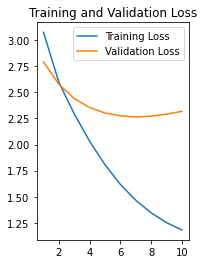

In [35]:
import matplotlib.pyplot as plt
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']

epochs_range = range(1,11)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [87]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=14):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
                                 tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [98]:
generate_text(model, tokenizer, init_sentence="<start> love ", max_len=15)

'<start> love is a beautiful thing <end> '

---
### 회고

- 인공지능 모델을 만들고 그 모델에게 단어를 주면 해당 단어를 시작으로 하는 노래 가사가 나온다는 것이 너무 신기했다. 지금까지는 컴퓨터가 어떠한 문제를 계산해서 분류하거나 답을 찾아내는 계산적인 부분만 했었는데 작문이라는 창작에대해서 제대로된 결과물이 나온다는 것이 너무 신기했다.


- vla_loss값이 생각보다 더 잘안떨어지고 모델을 학습하는데 걸리는 시간도 굉장히 길어서 하는데 조금 힘이 들었지만 그래도 이 프로젝트를 진행하면서 얻어간것도 많다고 생각한다.


- 다른 프로젝트를 했을때보다 더 많은 시간을 들이고 모델에 대해서도 더 깊이 찾아봤어서 나중에 이러한 프로젝트를 진행했을때 도움이 많이 될것 같다.


- 양방향 LSTM과 GRU 그리고 LSTM과 GRU를 같이 결합해서 쓸때와 LSTM만 사용하는 경우 등 RNN에 대해서 많이 찾아봤고 직접 값을 조정하면서 결과를 여러번 보니 어떤 상황일때 어떤 방법이 좋겠구나 하는 것도 경험적으로 얻어간것 같다.


- 그렇지만, 시간을 오래 사용했음에도 2.0이하의 val_loss를 얻지 못해서 아쉬움이 생기는것 같다.